In [10]:
%matplotlib inline 
import experiment as ex
import network_generation.generation as ng 
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import math

algorithm: 
- make a graph sample 
- compute distance matrix of the sample (NxN)
- isolate the driver nodes 
    - find nearest neighbor pairs from driver submatrix 
- take a random sample of nodes (random submatrix (N_DxN_D) )
    
function: 
- find the nearest neighbors (by euclidean distance) of each node in a set of nodes     

In [4]:
# compute the distance matrix of a set of nodes 
# positions is an N x d matrix of floats  
def compute_distance_matrix(positions):
    
    # number of nodes 
    n = len(positions)
    # number of dimensions 
    dim = len(positions[0])
    
    d = np.zeros((n,n))
    
    # upper triangle 
    for i in xrange(n):
        # some 'large' number for self distance
        d[i][i] = 100
        for j in xrange(i+1,n):
            dij = 0 
            # for each dimension 
            for k in xrange(dim):
                # compute distance 
                dist = abs(positions[i][k] - positions[j][k])
                dij += dist**2 
                
            # assign matrix element 
            d[i][j] = dij**0.5
                
    # symmetric 
    d = d + d.T 
    
    return d 


In [5]:
# given a distance matrix (list of lists), find the nearest neighbor pairs
def find_nearest_neighbors(matrix):
    
    # number of nodes 
    n = len(matrix)
    
    pairs = []
    distances = []
    # loop over each row
    for i in range(n):
        # get min of the i'th row 
        val, idx = min((val, idx) for (idx, val) in enumerate(matrix[i]))
        # check if the pair is already found -- only want unique distances 
        if [idx,i] in pairs:
            pass
        else:
            pairs.append([i,idx])
            distances.append(val)
        
    return np.array(distances) #, np.array(pairs) 

In [6]:
# given a distance matrix (list of lists), 
# find the mean of the 10% shortest nearest neighbor pairs

def find_mean_nearest_neighbors(matrix):
    
    # number of nodes 
    n = len(matrix)
    
    pairs = []
    nn_distances = []
    # loop over each row
    for i in range(n):
        # get min of the i'th row 
        val, idx = min((val, idx) for (idx, val) in enumerate(matrix[i]))
        
        # check if the pair is already found -- only want unique distances 
#         if [idx,i] in pairs:
#             pass
#         else:
        pairs.append([i,idx])
        nn_distances.append(val)
        
        # find shortest 10% of distances 
    cutoff_idx = int(math.ceil(0.1*len(nn_distances)))
    # throw out the shortest neighbor distance 
    mean_shortest = np.mean(np.sort(nn_distances)[1:cutoff_idx+1])
        
    return mean_shortest

In [7]:
# pick a random submatrix of distances

# input matrix and list of node locs 
def extract_submatrix(matrix,nodes):
    return matrix[np.ix_(nodes,nodes)]

# input matrix and size of random uniform sample 
def random_submatrix(matrix,num_nodes):
    sample = np.sort(np.random.choice(len(matrix), num_nodes, replace=False))
    return matrix[np.ix_(sample,sample)]

## find nearest neighbor links in an RGG

take the 5% shortest nearest neighbor distances 

mean of the closest 5% of distances over shuffles 
mean of the closest 5% of driver node distances 

you're losing a bit of power by mixing across trials
fix a trial and then compute a statistic for that trial:
   - subtract mean separation of bottom 5% of drivers from E(mean separation of bottom 5% of nodes)
   - E -- average over shuffles

look at the distribution of this difference across trials

if you have a repulsion effect then it'd show up in the shortest distances 
The minimum separation between any pair could work -- but it could be susceptible to outliers. 
You can see a touch of evidence for my claim in the histograms you provide.

Yes -- I don't know what to expect for our summary statistics with degree -- but you can always take means across trials.

## solid boundary

In [ ]:
# make an ensemble 
kappa = 10
n = 1000
d = 2
boundary = 's'
num_radii = 10
num_samples = 500

RGG = ng.RGGEnsemble(kappa,n,d, boundary=boundary,num_radii=num_radii)
RGG.generate_samples(n=num_samples)
RGG.to_LCC()

# for each trial (graph ensemble), find mean over 100 shuffles 
# store the difference in means of the shortest 5% for each graph ensemble and the shortest driver 5% 

In [12]:
driver_means = []
shuffle_means = []
differences = []
for sample in RGG.samples:
    # get positions 
    pos = sample.positions

    # find the distance matrix
    d_mat = compute_distance_matrix(pos)

    # get the distance matrix of the driver nodes 
    drivers = sample.find_unmatched()
    num_drivers = len(drivers)

    # extract driver node distance submatrix 
    driver_matrix = extract_submatrix(d_mat,drivers)
    # find nearest neighbor distances  
    driver_mean = find_mean_nearest_neighbors(driver_matrix)

    # draw random samples from the d_matrix 
    num_shuffles = 10
    shuffle_means = []
    for i in xrange(num_samples):
        sample_matrix = random_submatrix(d_mat,num_drivers)
        shuffle_means.append(find_mean_nearest_neighbors(sample_matrix))
    
    shuffle_mean_mean = np.mean(shuffle_means)
    differences.append(driver_mean - shuffle_mean_mean)

IndexError: index 998 is out of bounds for axis 0 with size 998

Ttest_1sampResult(statistic=1.3286021058430975, pvalue=0.18458652872075654)


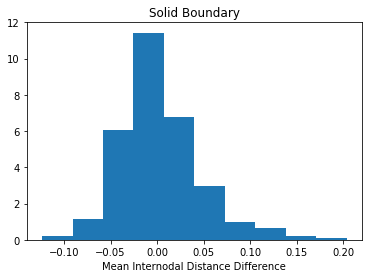

In [373]:
differences = np.sort(differences) 
        
plt.hist(differences,normed=1)
plt.xlabel('Mean Internodal Distance Difference')
plt.title('Solid Boundary')
np.mean(differences), stats.sem(differences)
plt.savefig('./plots/internodal_solid.png')

print stats.ttest_1samp(differences,0)

## periodic boundary 

In [349]:
# make an ensemble 
kappa = 10
n = 1000
d = 2
boundary = 'p'
num_radii = 10
num_samples = 500

RGGp = ng.RGGEnsemble(kappa,n,d, boundary=boundary,num_radii=num_radii)
RGGp.generate_samples(n=num_samples)

In [11]:
# for each trial (graph ensemble), find mean over 100 shuffles 
# store the difference in means of the shortest 5% for each graph ensemble and the shortest driver 5% 

driver_means = []
shuffle_means = []
differencesp = []

for sample in RGGp.samples:
    # get positions 
    pos = sample.positions

    # find the distance matrix
    d_mat = compute_distance_matrix(pos)

    # get the distance matrix of the driver nodes 
    drivers = sample.find_unmatched()
    num_drivers = len(drivers)

    # extract driver node distance submatrix 
    driver_matrix = extract_submatrix(d_mat,drivers)
    # find nearest neighbor distances  
    driver_mean = find_mean_nearest_neighbors(driver_matrix)

    # draw random samples from the d_matrix 
    num_shuffles = 10
    shuffle_means = []
    for i in xrange(num_samples):
        sample_matrix = random_submatrix(d_mat,num_drivers)
        shuffle_means.append(find_mean_nearest_neighbors(sample_matrix))
    
    shuffle_mean_mean = np.mean(shuffle_means)
    differencesp.append(driver_mean - shuffle_mean_mean)

NameError: name 'RGGp' is not defined

Ttest_1sampResult(statistic=1.28415841157299, pvalue=0.19968242945841364)


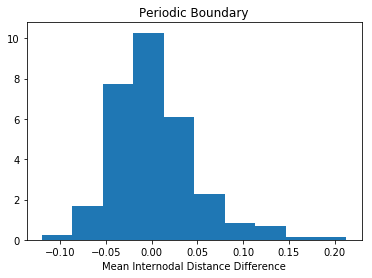

In [375]:
differencesp = np.sort(differencesp) 
        
plt.hist(differencesp,normed=1)
plt.xlabel('Mean Internodal Distance Difference')
plt.title('Periodic Boundary')
plt.savefig('./plots/internodal_periodic.png')

np.mean(differencesp), stats.sem(differencesp)
print stats.ttest_1samp(differencesp,0)